In [1]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-2osfjtel


In [2]:
# Download the tsai package
# !pip install -Uqq tsai

# Import the modules
from tsai.all import *
import sklearn.metrics as skm

# Trace the setup
my_setup()

os              : Linux-5.10.147+-x86_64-with-glibc2.31
python          : 3.9.16
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.13.1+cu116
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [15.0] GB


In [6]:
# Download ETTh1 monthly
df = get_long_term_forecasting_data(dsid="ETTh1",
                                    task="M",
                                    force_download=True,
                                    verbose=True)
# Sort by date
df = df.sort_values(by="date",
                    ignore_index=True)
# Trace
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


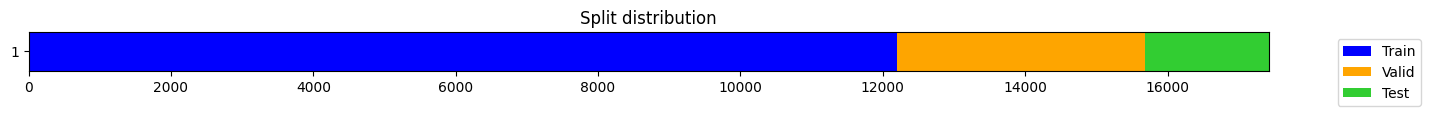

((#12194) [0,1,2,3,4,5,6,7,8,9...],
 (#3484) [12194,12195,12196,12197,12198,12199,12200,12201,12202,12203...],
 (#1742) [15678,15679,15680,15681,15682,15683,15684,15685,15686,15687...])

In [4]:
# Convert the frame into a numpy array in 3d form
X, y = df2xy(df=df.loc[:, df.columns != "date"],
             target_col="OT")
# Split the data [70%, 20%, 10%]
splits = get_splits(o=y,
                    valid_size=.2,
                    test_size=.1,
                    stratify=False,
                    random_state=43,
                    shuffle=False)
# Trace
splits

In [5]:
X.shape

(17420, 1, 6)

In [17]:
# Create the DataLoaders object
dls = get_ts_dls(X=X, y=y,
                 splits=splits,
                 tfms=[None, [TSRegression()]],
                 batch_tfms=TSStandardize(by_sample=True, by_var=True))
# Trace
dls.one_batch()

(TSTensor(samples:64, vars:1, len:6, device=cuda:0, dtype=torch.float32),
 tensor([18.0090, 20.0490, 18.2200,  6.9640, 27.1540,  9.9190,  6.9640, 31.8670,
         11.6070, 21.8780, 11.1150, 23.9880, 11.1150, 19.4860,  4.7130, 25.8880,
         33.3440, 15.8980, 19.2750, 13.9290, 10.6220,  9.2860, 25.5360,  9.2150,
         10.6220,  7.4570, 30.8820,  6.1200, 18.0790, 21.0340, 19.7680, 16.7430,
         12.3810,  3.4470, 16.4610,  6.8940, 19.4860, 21.4560, 11.8890,  8.0900,
         19.6270, 19.1340, 28.1390, 23.7070, 16.4610, 17.3050, 33.5560, 42.7710,
         10.8330,  7.2460, 13.9990, 10.7630, 20.7520, 13.0850,  8.3710, 20.8230,
         18.7830, 26.6620, 10.9040,  5.3460,  4.1500, 14.7030, 17.5870, 23.0740],
        device='cuda:0'))

In [ ]:
# Trace lengths
len(dls.train.dataset), len(dls.valid.dataset), len(dls[2].dataset)

(12194, 3484, 1742)

SuggestedLRs(valley=0.010964781977236271)

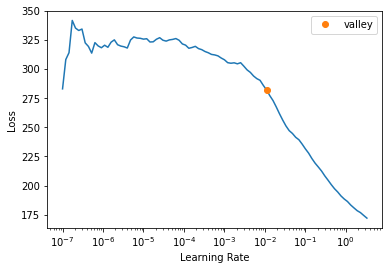

In [ ]:
# Create a ts learner [InceptionTime]
learn = ts_learner(dls=dls,
                   arch="InceptionTime",
                   metrics=[rmse, mae],
                   cbs=[SaveModel(),
                        ShowGraph()])
# Find optimum learning rate
learn.lr_find()

epoch,train_loss,valid_loss,_rmse,mae,time
0,59.028282,155.861099,12.484433,11.856790,00:04
1,51.112114,176.216705,13.274665,12.702168,00:04
2,51.384624,213.767426,14.620788,13.942172,00:04
3,49.861874,336.052734,18.331741,17.288166,00:04
4,51.195782,241.627655,15.544377,14.754175,00:04
5,50.846630,187.627747,13.697729,13.096655,00:04
6,49.977711,241.697372,15.546618,14.685423,00:04
7,50.220451,265.953339,16.308075,15.445430,00:04
8,51.331318,245.391205,15.664966,14.798143,00:05
9,49.535786,252.774628,15.898888,14.939052,00:08


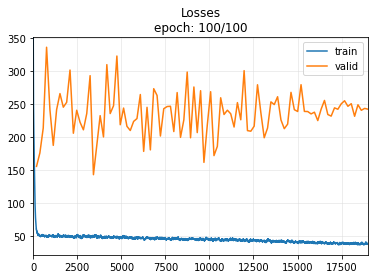

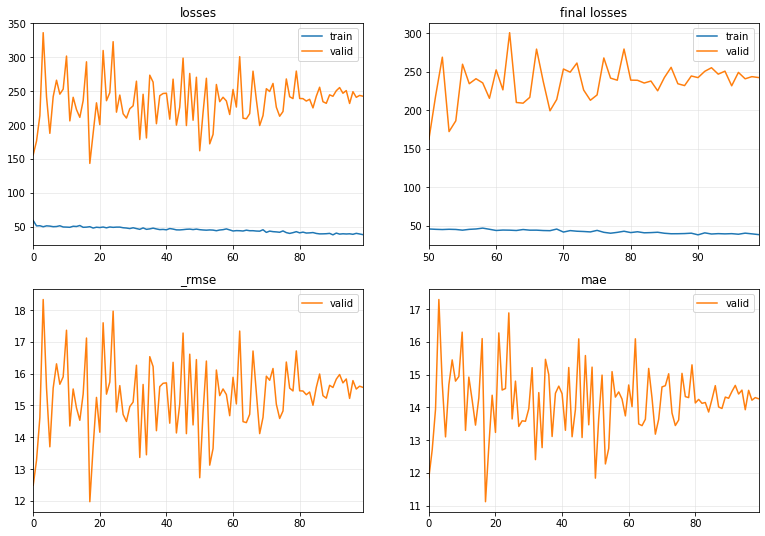

In [ ]:
# Fit by one_cycle method
learn.fit_one_cycle(n_epoch=100,
                    lr_max=0.03)

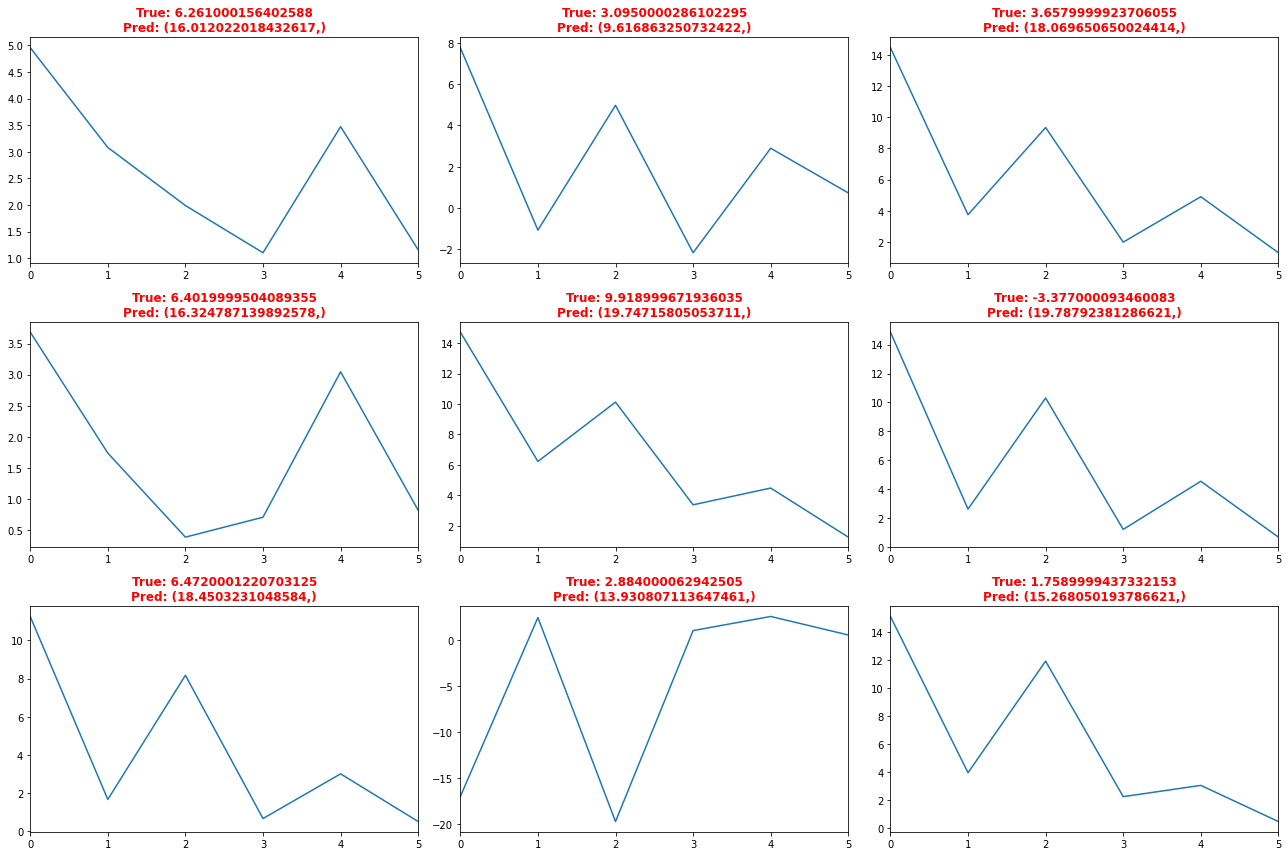

In [ ]:
# Trace the results
learn.show_results()

In [ ]:
# Predict
probas, targets = learn.get_preds(dl=dls[2])
# Evaluate the test set
rmse(preds=probas, targs=targets)

TensorBase(6.5561)